In [1]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

import scipy.sparse
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm
from scipy import stats

import gensim
import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize, punkt
from gensim.models import KeyedVectors

import matplotlib.collections as plt1
import matplotlib.pyplot as plt2
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import pandas as pd
pd.set_option('display.max_columns', 50)

import pickle
import time
import re
import csv
import math
import pickle
import time
import spacy

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/yhu2bk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#data frame with only labeled abstracts
df_lab = pd.read_csv("/home/seh6fy/git/publicrd/data/prd/Digital_abstract_labelled/labelled_abstracts.csv")

#data frame with all of the abstracts
df = pd.read_pickle("/home/seh6fy/git/publicrd/data/prd/Paper/FR_meta_and_final_tokens_23DEC21.pkl")

In [3]:
# Remove Null Abstracts. Reset the index and create a variable index to link with PROJECT_ID
df = df[~df.ABSTRACT.isnull()]
df.reset_index(inplace = True, drop = True)
df['index'] = df.index
df.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,index
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...,0
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...,1
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...,2
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...,3
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...,4


In [4]:
df_lab = df_lab[['PROJECT_ID','ABSTRACT','Is it related to Big-Data','label']]
df_lab.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label
0,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Big-data
1,1178172,Project Summary/AbstractThe establishment of t...,1,Big-data
2,163037,DESCRIPTION (provided by applicant): The long-...,0,Non Big-data
3,880197,DESCRIPTION (provided by applicant): The most ...,0,Non Big-data
4,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Non Big-data


In [5]:
# Make a list of PROJECT_ID from the labelled data
project_id_lab = list(df_lab['PROJECT_ID'])

# Find the index of those PROJECT_ID in the overall data. first convert PROJECT_ID into numeric
df['PROJECT_ID'] = pd.to_numeric(df['PROJECT_ID'])
subset_df = df.loc[df['PROJECT_ID'].isin(project_id_lab),['index', 'PROJECT_ID']]
index_lab = list(subset_df['index'])

# merge with the labelled data using PROJECT_ID.
df_lab = df_lab.merge(subset_df, how='left', on='PROJECT_ID')
df_lab.sort_values("index")
df_lab.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,index
0,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Big-data,828928
1,1178172,Project Summary/AbstractThe establishment of t...,1,Big-data,989609
2,163037,DESCRIPTION (provided by applicant): The long-...,0,Non Big-data,24794
3,880197,DESCRIPTION (provided by applicant): The most ...,0,Non Big-data,776107
4,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Non Big-data,709656


# 1. TFIDF approach

## 1.1. Vectorize, build the training and test sample

In [6]:
# Compute the TFIDF matrix on the full data
v = TfidfVectorizer()
tfidf = v.fit_transform(df['ABSTRACT'])

In [7]:
# Subset the TFIDF matrix on labelled data: select rows corresponding to the index
tfidf_lab = tfidf[index_lab,:]
tfidf_lab.shape

(1200, 1307953)

In [42]:
# Build the training and test sample: randomly select 80% of index_lab as training and the rest as test
import random

# Build the index for the training and the test
index_training = random.sample(index_lab, int(0.8 * len(index_lab)))
index_test = list(set(index_lab) - set(index_training))

# sort those index (sort help to extract the Y value for each set)
index_training.sort()
index_test.sort()

# Extract those index in the TFIDF matrix and compute the X training and Test
X_train_tfidf = tfidf[index_training,:]
X_test_tfidf = tfidf[index_test,:]

In [43]:
# Create Y for training and test using the index order from the sampling
Y_train_tfidf = [df_lab.loc[df_lab['index']== i,'label'].values.tolist() for i in index_training]
Y_train_tfidf = sum(Y_train_tfidf, [])

Y_test_tfidf = [df_lab.loc[df_lab['index']== i,'label'].values.tolist() for i in index_test]
Y_test_tfidf = sum(Y_test_tfidf, [])

## 1.2. KNN classifier

In [44]:
# number of neighbors
k = int(math.sqrt(len(Y_train_tfidf)))
print('Number of neighbors:', k)

Number of neighbors: 30


In [45]:
# Run KNN
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors= k)
classifier.fit(X_train_tfidf,Y_train_tfidf)

KNeighborsClassifier(n_neighbors=30)

In [46]:
# Predict the classification
Y_pred_tfidf = classifier.predict(X_test_tfidf)

In [47]:
# Classifier performance
from sklearn.metrics import classification_report, confusion_matrix

confusion = confusion_matrix(Y_test_tfidf, Y_pred_tfidf)
#print(confusion)
print(classification_report(Y_test_tfidf, Y_pred_tfidf))

              precision    recall  f1-score   support

    Big-data       0.68      0.97      0.80       106
Non Big-data       0.97      0.64      0.77       134

    accuracy                           0.79       240
   macro avg       0.82      0.81      0.79       240
weighted avg       0.84      0.79      0.78       240



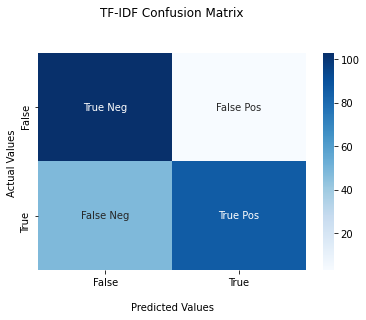

<Figure size 432x288 with 0 Axes>

In [48]:
import seaborn as sns
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')
ax.set_title('TF-IDF Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt2.show()
plt2.savefig('tfidf.PNG')

In [49]:
# Predict the classification for the whole data: use the whole TFIDF
Y_tfidf = classifier.predict(tfidf)

# The TFIDF keep the order from index. Just add the prediction as new variable
df['Prediction_TFIDF'] = Y_tfidf
df.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,index,Prediction_TFIDF
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...,0,Big-data
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...,1,Big-data
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...,2,Big-data
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...,3,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...,4,Big-data


In [50]:
# Count the number of projects that is Big data related
df_bigdata = df[df['Prediction_TFIDF']=='Big-data']
print('Number of abstracts related to Big data:', len(df_bigdata))

Number of abstracts related to Big data: 327066


In [51]:
cb_pal = {"blue":'#377eb8', "orange":'#ff7f00', "green":'#4daf4a', "pink":'#f781bf', "brown":'#a65628', 
          "purple":'#984ea3', "gray":'#999999', "red":'#e41a1c', "yellow":'#dede00'}

<ipython-input-52-a496b776c9c3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bigdata["FY"] = df_bigdata["FY"].astype('int')
<ipython-input-52-a496b776c9c3>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


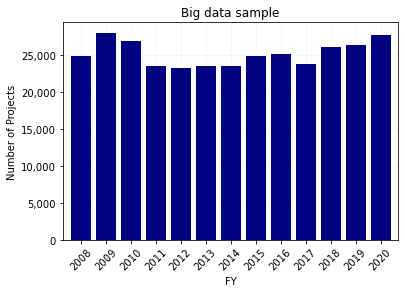

In [52]:
# Distribution over time and agencies
df_bigdata["FY"] = df_bigdata["FY"].astype('int')
year_counts = df_bigdata['FY'].value_counts().sort_index(ascending=True)

# Distribution
year = year_counts.index.tolist()
count = year_counts.values

fig = plt2.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt2.grid(True, color = "whitesmoke")
plt2.bar(year, count, color='navy')
#plt.xlim(-0.7, len(year)-0.3)
plt2.xlim(2007.3,2020.7)
plt2.xticks(year, rotation=45)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt2.xlabel("FY")
plt2.ylabel("Number of Projects")
plt2.title("Big data sample")

plt2.savefig("big_data_time.png", dpi = 800, bbox_inches = "tight")

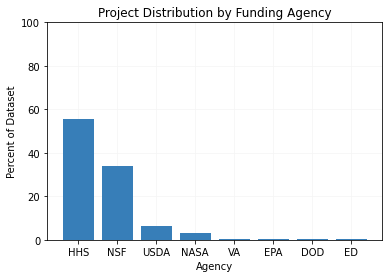

In [53]:
agency_counts = 100*df_bigdata["DEPARTMENT"].value_counts()/len(df_bigdata)
agency = agency_counts.index.tolist()
count = agency_counts.values

fig = plt2.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt2.grid(True, color = "whitesmoke")
plt2.bar(agency, count, color=cb_pal['blue'])
plt2.ylim(0,100)
plt2.xlabel("Agency")
plt2.ylabel("Percent of Dataset")
plt2.title("Project Distribution by Funding Agency")

plt2.savefig("big_data_agency.png", dpi = 800, bbox_inches = "tight")

In [54]:
# save the data
df_bigdata.to_csv("/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/tfidf_method.csv")

# 2. Doc2Vec approach

## 2.1 Vectorize and build both training and test sample

In [51]:
# Build the tagged data

data = df['ABSTRACT']
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
tagged_df = pd.DataFrame(tagged_data)

# new dataframe of tagged words
df['words'] = tagged_df['words']
df['tags'] = tagged_df['tags']
df.head()

# save the tagged document as the model
tagged_df.to_csv("/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/tagged_df.csv")

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,index,Prediction_TFIDF,words,tags
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...,0,Big-data,"[this, is, a, project, to, explore, game-based...",[0]
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...,1,Big-data,"[institution, :, franklin, institute, science,...",[1]
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...,2,Big-data,"[through, programs, (, including, small, group...",[2]
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...,3,Big-data,"[in, partnership, with, the, american, chemica...",[3]
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...,4,Big-data,"[the, center, for, molecular, interfacing, (, ...",[4]


In [ ]:
# Run the doc2vec model. Only if the model is not save
size = 300
model = gensim.models.doc2vec.Doc2Vec(vector_size=size, epochs=15)   #min_count=2 - min number of times it shows up
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
model.save("/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/doc2vec_model/d2v.model")

In [86]:
# load the model and the tagged data
from ast import literal_eval
data = df['ABSTRACT']
#tagged_df = pd.read_csv("/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/tagged_df.csv")
model = Doc2Vec.load("/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/doc2vec_model/d2v.model")
#tagged_df['tags']=tagged_df['tags'].strip('][').split(', ')
tagged_df = pd.read_csv("/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/tagged_df.csv", converters={'tags': literal_eval})
# new dataframe of tagged words
df['words'] = tagged_df['words']
df['tags'] = tagged_df['tags']

# Build the vector representation of all the abstracts
vector = []
for i in range(0, len(df)):
    vectorthis = (model.dv[df['tags'][i]])
    vector.append(vectorthis[0])

In [89]:
# Select the training and the test sample
X_train_doc2vec = []
X_test_doc2vec = []

for i in range(0, len(index_training)):
    vectorthis = model.dv[df['tags'][index_training[i]]].tolist()
    X_train_doc2vec.append(vectorthis[0])
                           
for i in range(0, len(index_test)):
    vectorthis = model.dv[df['tags'][index_test[i]]].tolist()
    X_test_doc2vec.append(vectorthis[0])

In [90]:
# Create Y for training and test using the index order from the sampling
Y_train_doc2vec = [df_lab.loc[df_lab['index']== i,'label'].values.tolist() for i in index_training]
Y_train_doc2vec = sum(Y_train_doc2vec, [])

Y_test_doc2vec = [df_lab.loc[df_lab['index']== i,'label'].values.tolist() for i in index_test]
Y_test_doc2vec = sum(Y_test_doc2vec, [])

## 2.1. KNN using Doc2Vec

In [91]:
# number of neighbors
k = int(math.sqrt(len(Y_train_doc2vec)))
print('Number of neighbors:', k)

Number of neighbors: 30


In [111]:
# Run KNN
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors= 50)
classifier.fit(X_train_doc2vec,Y_train_doc2vec)

KNeighborsClassifier(n_neighbors=50)

In [112]:
# Predict the classification
Y_pred_doc2vec = classifier.predict(X_test_doc2vec)

# Classifier performance
from sklearn.metrics import classification_report, confusion_matrix

confusion_doc2vec = confusion_matrix(Y_test_doc2vec, Y_pred_doc2vec)
print(classification_report(Y_test_doc2vec, Y_pred_doc2vec))

              precision    recall  f1-score   support

    Big-data       1.00      0.03      0.06       106
Non Big-data       0.57      1.00      0.72       134

    accuracy                           0.57       240
   macro avg       0.78      0.51      0.39       240
weighted avg       0.76      0.57      0.43       240



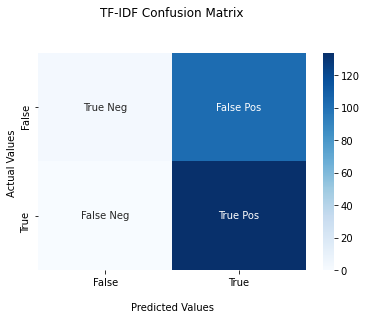

<Figure size 432x288 with 0 Axes>

In [113]:
import seaborn as sns
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(confusion_doc2vec, annot=labels, fmt='', cmap='Blues')
ax.set_title('TF-IDF Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt2.show()
plt2.savefig('doc2vec.PNG')

In [98]:
# Predict the classification for the whole data: use the whole TFIDF
Y_doc2vec = classifier.predict(vector)

# The TFIDF keep the order from index. Just add the prediction as new variable
df['Prediction_Doc2vec'] = Y_doc2vec
df.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,index,Prediction_TFIDF,words,tags,Prediction_Doc2vec
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...,0,Big-data,"['this', 'is', 'a', 'project', 'to', 'explore'...",[0],Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...,1,Big-data,"['institution', ':', 'franklin', 'institute', ...",[1],Non Big-data
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...,2,Big-data,"['through', 'programs', '(', 'including', 'sma...",[2],Non Big-data
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...,3,Non Big-data,"['in', 'partnership', 'with', 'the', 'american...",[3],Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...,4,Big-data,"['the', 'center', 'for', 'molecular', 'interfa...",[4],Non Big-data


In [99]:
# Count the number of projects that is Big data related
df_bigdata = df[df['Prediction_Doc2vec']=='Big-data']
print('Number of abstracts related to Big data:', len(df_bigdata))

Number of abstracts related to Big data: 391


<ipython-input-100-c070838aba88>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bigdata["FY"] = df_bigdata["FY"].astype('int')
<ipython-input-100-c070838aba88>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


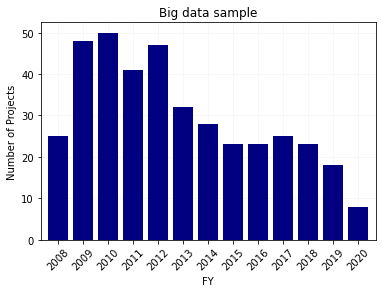

In [100]:
# Distribution over time and agencies
df_bigdata["FY"] = df_bigdata["FY"].astype('int')
year_counts = df_bigdata['FY'].value_counts().sort_index(ascending=True)

# Distribution
year = year_counts.index.tolist()
count = year_counts.values

fig = plt2.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt2.grid(True, color = "whitesmoke")
plt2.bar(year, count, color='navy')
#plt.xlim(-0.7, len(year)-0.3)
plt2.xlim(2007.3,2020.7)
plt2.xticks(year, rotation=45)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt2.xlabel("FY")
plt2.ylabel("Number of Projects")
plt2.title("Big data sample")

plt2.savefig("big_data_time_doc2vec.png", dpi = 800, bbox_inches = "tight")

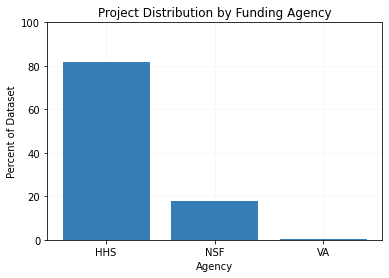

In [101]:
agency_counts = 100*df_bigdata["DEPARTMENT"].value_counts()/len(df_bigdata)
agency = agency_counts.index.tolist()
count = agency_counts.values

fig = plt2.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt2.grid(True, color = "whitesmoke")
plt2.bar(agency, count, color=cb_pal['blue'])
plt2.ylim(0,100)
plt2.xlabel("Agency")
plt2.ylabel("Percent of Dataset")
plt2.title("Project Distribution by Funding Agency")

plt2.savefig("big_data_agency_doc2vecpng", dpi = 800, bbox_inches = "tight")